<a href="https://colab.research.google.com/github/Meghana0405/FMML-LAB-1/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-14 13:26:22--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.25.45, 18.65.25.112, 18.65.25.85, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.25.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  83.5MB/s    in 0.5s    

2024-05-14 13:26:23 (83.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


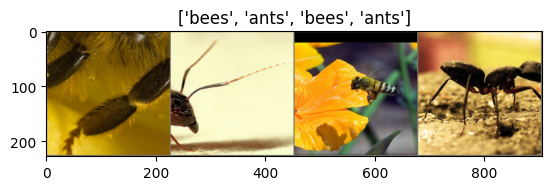

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 101MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6400 Acc: 0.7049

Epoch 1/4
----------
Loss: 0.5140 Acc: 0.7664

Epoch 2/4
----------
Loss: 0.4052 Acc: 0.8443

Epoch 3/4
----------
Loss: 0.5951 Acc: 0.7869

Epoch 4/4
----------
Loss: 0.3709 Acc: 0.8648



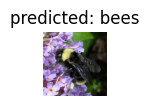

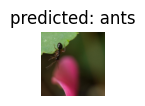

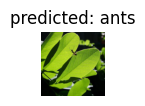

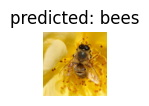

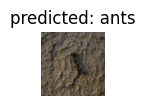

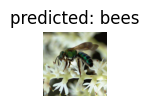

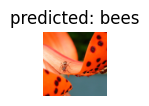

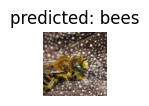

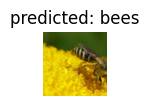

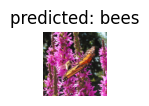

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?
Data augmentation techniques, such as resizing, cropping, rotating, flipping, or adding noise to training data, are significant in machine learning and especially in computer vision tasks for several reasons:

Increased Robustness: By applying various transformations to the training data, the model learns to be more robust to changes in the input data during inference. For example, if your model is meant to recognize objects in images, it should be able to do so regardless of slight variations in size, orientation, or position of the objects within the image.

Improved Generalization: Data augmentation helps prevent overfitting by exposing the model to a wider variety of examples. Instead of learning specific features of the training images, the model learns to focus on the more general features that are invariant to these transformations.

Increased Diversity: Augmenting the training data creates more diverse examples, which helps the model learn a richer set of features. This is particularly important when the original dataset is limited in size or diversity.

Reduced Memorization: Without data augmentation, the model might simply memorize the training examples rather than learning to generalize from them. By presenting the model with transformed versions of the data, we discourage it from memorizing specific instances and encourage it to learn more abstract representations.

Better Utilization of Data: Data augmentation allows us to generate more training examples from a limited dataset, which can be especially valuable when collecting new data is expensive or time-consuming.

Addressing Class Imbalance: In classification tasks with imbalanced classes, data augmentation techniques can be used to balance the distribution of classes in the training set, thereby preventing the model from being biased towards the majority class.

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)
If you don't use a pre-trained ResNet model and instead train it from scratch (i.e., with pretrained=False), the performance of the model might be significantly lower compared to using a pre-trained model.

Training a deep neural network from scratch requires a large amount of labeled data and computational resources. Without the benefits of transfer learning from pre-trained weights, the model would need to learn meaningful representations of the data entirely from scratch, which can be challenging, especially with limited training data.

The performance you achieve would depend on various factors including:

Size and quality of the training dataset: A larger and more diverse dataset generally leads to better performance.

Model architecture and hyperparameters: The specific architecture of the ResNet model (e.g., number of layers) and the hyperparameters chosen for training (e.g., learning rate, batch size) can significantly impact performance.

Computational resources: Training deep neural networks from scratch requires significant computational resources, including GPUs or TPUs, as well as time.

Training methodology: The training process, including data preprocessing, data augmentation, and optimization algorithms, can also affect performance.

Without pre-training, the model would start with random weights, which means it would take longer to converge and might not reach the same level of performance compared to using pre-trained weights. Additionally, it might be more prone to overfitting, especially with limited training data.

If you're interested in experimenting with training a ResNet model from scratch, you could try it out using your dataset and monitoring the performance metrics such as accuracy, loss, and any relevant evaluation metrics for your specific task.

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?
Using a pre-trained ResNet model that was trained on a dataset significantly different from the ants vs bees dataset can still provide good performance, albeit with some considerations.

Here's why:

Feature Extraction: Pre-trained models like ResNet learn to extract generic features from images that are useful for a wide range of tasks. These features often capture general visual patterns such as edges, textures, and object parts. Even if the pre-training dataset is different from the target dataset (e.g., ImageNet), many of these features can still be relevant for tasks like object recognition, including the ants vs bees classification.

Transfer Learning: The primary benefit of using pre-trained models is transfer learning. Even though the pre-training dataset may be different, the learned features can still serve as a good starting point for learning on the target dataset. By fine-tuning the pre-trained model on the ants vs bees dataset, the model can adapt its learned features to better suit the characteristics of the new dataset.

Regularization: Pre-training on a large and diverse dataset like ImageNet often helps in regularization. The model learns to generalize better and avoids overfitting, which is beneficial when fine-tuning on smaller datasets like ants vs bees.

However, there are also potential challenges:

Domain Shift: If the target dataset (ants vs bees) is significantly different from the pre-training dataset, there might be a domain shift. This means that some of the learned features may not be directly applicable or may need adjustment to be effective for the target task.

Specificity of Features: The pre-trained model might have learned features that are specific to the original dataset. In such cases, fine-tuning may be necessary to adapt these features to the new dataset.

Overall, while using a pre-trained ResNet model can still provide a good starting point for training on the ants vs bees dataset, it's important to fine-tune the model and possibly adjust its architecture or training procedure to achieve optimal performance for the specific task and dataset at hand.